<a href="https://colab.research.google.com/github/choheemun/text-1/blob/master/%EC%8A%A4%ED%83%80%EC%9D%BC%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install torch torchvision

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
# 필요한 이미지들을 다운받습니다.
import os
os.getcwd()

!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/content")
  os.mkdir("images/style")
except:
  pass

!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -P images/content
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -P images/style

rm: cannot remove 'images': No such file or directory
--2020-01-21 12:10:01--  https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406531 (397K) [image/jpeg]
Saving to: ‘images/content/Tuebingen_Neckarfront.jpg’

Tuebingen_Neckarfro 100%[===================>] 397.00K  --.-KB/s    in 0.02s   

2020-01-21 12:10:01 (17.7 MB/s) - ‘images/content/Tuebingen_Neckarfront.jpg’ saved [406531/406531]

--2020-01-21 12:10:03--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
# 컨텐츠 손실을 어느 지점에서 맞출것인지 지정해놓습니다.
content_layer_num = 1
image_size = 512
epoch = 5000

In [ ]:
content_dir = "./images/content/Tuebingen_Neckarfront.jpg"
style_dir = "./images/style/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

In [ ]:
# 이미 학습된 ResNet 모델이 이미지넷으로 학습된 모델이기 때문에 이에 따라 정규화해줍니다.

def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[1,1,1]),
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img

In [ ]:
# 정규화 된 상태로 연산을 진행하고 다시 이미지화 해서 보기위해 뺐던 값들을 다시 더해줍니다.
# 또한 이미지가 0에서 1사이의 값을 가지게 해줍니다.

def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1,1,1])
    img = transform(tensor.clone())
    img = img.clamp(0,1)
    img = torch.transpose(img,0,1)
    img = torch.transpose(img,1,2)
    return img

In [ ]:
# 미리 학습된 resnet50를 사용합니다.
resnet = models.resnet50(pretrained=True)
for name,module in resnet.named_children():
    print(name)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.1MB/s]


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
# 레이어마다 결과값을 가져올 수 있게 forward를 정의합니다.

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

In [ ]:
# 그람 행렬을 생성하는 클래스 및 함수를 정의합니다. 
# [batch,channel,height,width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        return G

In [ ]:
# 모델을 학습의 대상이 아니기 때문에 requires_grad를 False로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

resnet = Resnet().to(device)          # 우리가 정의한 class Resnet을 인스턴스화
for param in resnet.parameters():
    param.requires_grad = False

cuda:0


In [ ]:
# 그람행렬간의 손실을 계산하는 클래스 및 함수를 정의합니다.

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

False False True


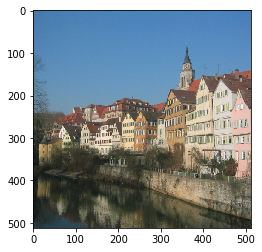

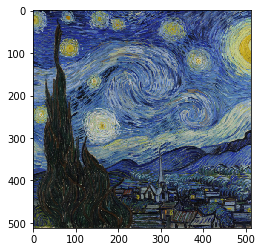

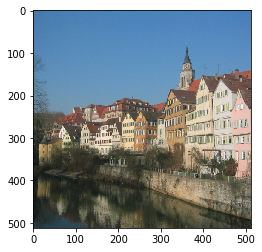

In [ ]:
# 컨텐츠 이미지, 스타일 이미지, 학습의 대상이 되는 이미지를 정의합니다.

content = image_preprocess(content_dir).to(device)     # nn.Sequential 같은 layer 가 아닌 변수는 일단 requires_grad 가 없다 / nn는 기본적으로 requires_grad=True 인듯
style = image_preprocess(style_dir).to(device)         #따라서 requires_grad=False
generated = content.clone().requires_grad_().to(device)  # 변수 generated 는 requires_grad 를 주었으며, 이경우 디폴트가 True!!!!!

print(content.requires_grad,style.requires_grad,generated.requires_grad)  # 디폴트값이 True!!!!!

# 각각을 시각화 합니다.

plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

In [ ]:
# 목표값을 설정하고 행렬의 크기에 따른 가중치도 함께 정의해놓습니다
                                                                       #어떤 image의 'style'은 GramMatrix 의 return 이다./각 layers 마다의 style 이므로 '리스트'로 리턴
style_target = list(GramMatrix().to(device)(i) for i in resnet(style)) #더 정확히 말하면 각 layer의 FM을 class GramMatrix에 넣어 'style'을 리턴
content_target = resnet(content)[content_layer_num]    # content_layer_num='1' / resnet=Resnet() / renet(content) 의 리턴은 out_0 ~ out_5인데 그중 out_1이라는것
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

In [ ]:
# LBFGS 최적화 함수를 사용합니다.
# 이때 학습의 대상은 모델의 가중치가 아닌 이미지 자체입니다.
# for more info about LBFGS -> http://pytorch.org/docs/optim.html?highlight=lbfgs#torch.optim.LBFGS

optimizer = optim.LBFGS([generated])   # optimizer=optim.SGD(model) 과 비교해 보면 'generated'를 update한다는 것을 알수있다.

iteration = [0]
while iteration[0] < epoch:
    def closure():             # 입력인자가 없는 함수이다.
        optimizer.zero_grad()    # 한번 돌고나면 grad를 0으로 초기화 시킨다음 다시 계산한다.
        out = resnet(generated)  # iteration 마다 generated 가 update되므로 'out'도 계속 update된다.
        
        # 스타일 손실을 각각의 목표값에 따라 계산하고 이를 리스트로 저장합니다.
        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        # 복잡해 보이지만 결국 out[i]와 style_target[i]와의 MSE 이다. -> 결과는 리스트이다.
        #iteration마다 out은 변하지만 style_target은 변하지 않음
        
        # 컨텐츠 손실은 지정한 위치에서만 계산되므로 하나의 수치로 저장됩니다.
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)
        #content_target=resnet(content)[content_layer_num=1]
        # out=resnet(generated)              -> 즉 content loss는 generated와 content가 Resnet을 통과해서 만들어진 FM의 특정 층(layer1)을 MSE 하는것
        #iteration마다 out은 변하지만, content_target은 변하지 않음

        # 스타일:컨텐츠 = 1000:1의 비중으로 총 손실을 계산합니다.
        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)   #weighted sum/ content_loss는 리스트이므로 미리 합쳐놓고 weighted sum(아니다. 리스트아니다.)
        total_loss.backward()                                             # BP는 '총 loss'(total loss)를 BP

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss

    optimizer.step(closure)    # 이구조가 LBFGS의 특징이다. 원래는 optimizer.step()으로 끝나는데 LBFGS는 ()에 미리 정의된 closure가 들어간다
                              #optimizer.step을 거쳐야 generated가 update된다. (closure에 1차 미분값이 들어있는듯 )

tensor(1257400.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4315, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9892, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8780, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3515, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0471, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7097, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6129, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4779, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4301, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3904, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3570, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3297, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2848, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2665, device='cuda:0', grad_fn=<A

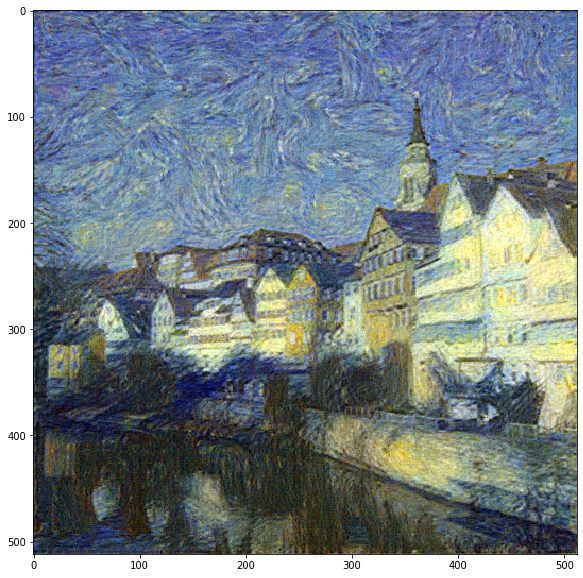

In [ ]:
# 학습된 결과 이미지를 확인합니다.

gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()

In [ ]:
import os
os.getcwd()



'/content'

In [ ]:
a=torch.Tensor(2,3)
b=torch.Tensor(2,3)
c=torch.Tensor(2,3)
c.requires_grad_()   # requires_
print(a.requires_grad,b.requires_grad,c.requires_grad)    # 'grad 를 계산하겠다'고 하면 일단 requires_grad=True 임

False False True
